<a href="https://colab.research.google.com/github/weix0026/InventoryManagement/blob/main/RandomForestStockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install yfinance
!pip install --upgrade yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 5.6 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
#********************************
# Author: Yu Wei
# 05/29/2022
#********************************

#We will create random forest model and use it to predict tomorrow's stock prices
import seaborn as sns

import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

import datetime
from dateutil.relativedelta import relativedelta
from pytz import timezone

mountain = timezone('US/Mountain')

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer

import requests

url="https://www.census.gov/economic-indicators/calendar-listview.html"
df_list_kpidate = pd.read_html(url)
df_list_kpidate = df_list_kpidate[0]
df_list_kpidate.columns = df_list_kpidate.iloc[0]
df_list_kpidate = df_list_kpidate[1:]
df_list_kpidate['Release Date'] =  pd.to_datetime(df_list_kpidate['Release Date'])

currentDatetime = datetime.datetime.now(mountain)
tomorrowDatetime = (currentDatetime + datetime.timedelta(days=1)).date()
tomorrowDatetime = datetime.datetime.strftime(tomorrowDatetime, '%Y-%m-%d')
df_list_kpidate = df_list_kpidate[df_list_kpidate['Release Date'] == tomorrowDatetime]
print(df_list_kpidate)

# Those are the stocks used as explanatory variables
tickers_list = ['SPY',
                'QQQ',
                'DIA', 
                '^VIX', 
                'MSFT',"GOOGL","AAPL","AMZN",
                'TSLA',
                'ARKK','PYPL', 
                'FDX',
                'CAT',
                'F',
                "VCR",#'COST',
                "DBC",'XLE','GLD',
                'CNYA','BABA',
                'SOXX','NVDA','AMD','INTC',
                'LUV',
                "XLF",
                'TLT',
                'LMT',
                '^TNX',
                '^TYX',
                '^FVX'
                ]

# You can select the starting time of data downloads
data =  yf.download(tickers_list,'2022-01-10',currentDatetime)['Adj Close']
data =  data.reset_index() # need to reset index 
dataV = yf.download(tickers_list,'2022-01-10',currentDatetime)['Volume']
dataV = dataV.reset_index() # need to reset index 

# Those are stocks you are interested in predicting
# We can predict tickers that are not in the predictor variable
# but we will lose the power from time series analysis
predictedVar_list = ['SPY',
                     'QQQ',
                    'DIA', 
                    #'^VIX', 
                    'MSFT',"GOOGL","AAPL",
                    "AMZN",
                    'TSLA',
                    'ARKK','PYPL', 
                    'FDX',
                    'CAT',
                    'BABA',
                    'F',
                    "VCR",#'COST',
                    "DBC",'XLE',
                    'SOXX',
                    #'ABNB',
                    'NVDA','AMD','INTC',
                    'LUV',
                    "XLF"
                    ]

# Empty list used to save the probability
predictedProb_list = []
# We will predict each stock 
for predictedVar in predictedVar_list:
    # data is used to save the adj close price only
    # Just use the 3 lines to calculate the price change
    # and convert up and down as binary
    # only extract price change starting from the seventh record
    # represent the price change from the sixth day to the seventh day
    a=data[predictedVar][1:] # day t
    b=data[predictedVar][0:-1]  # day t-1
    y=(a.reset_index()-b.reset_index())[6:].reset_index(drop=True)
    y[predictedVar][y[predictedVar] <= 0] = 0
    y[predictedVar][y[predictedVar] >  0] = 1
    y[predictedVar] = y[predictedVar].map({1:'yes', 0:'no'})

    for num_randomruns in range(1): 
        # Randomly drop N items from the predictor list except the predicted var
        # We will always keep the predicted variable so we can maintain the time
        # series for that variable
        candidate_ticker_to_drop = [x for x in tickers_list if x != predictedVar and x!= 'SPY' and x!= 'QQQ'] 
        droptickers=random.sample(candidate_ticker_to_drop, 0)
        print("Candidate tickers could be dropped from the predictors, ", candidate_ticker_to_drop)      
        print("Tickers would be dropped from the predictors in this run, ",droptickers)
          
        x_6=data.drop(droptickers+['Date'], axis=1)[1:-6].reset_index(drop=True)
        x_5=data.drop(droptickers+['Date'], axis=1)[2:-5].reset_index(drop=True)
        x_4=data.drop(droptickers+['Date'], axis=1)[3:-4].reset_index(drop=True)
        x_3=data.drop(droptickers+['Date'], axis=1)[4:-3].reset_index(drop=True)
        x_2=data.drop(droptickers+['Date'], axis=1)[5:-2].reset_index(drop=True)
        x_1=data.drop(droptickers+['Date'], axis=1)[6:-1].reset_index(drop=True)

        x_1 = x_1.add_suffix('_1')
        x_2 = x_2.add_suffix('_2')
        x_3 = x_3.add_suffix('_3')
        x_4 = x_4.add_suffix('_4')
        x_5 = x_5.add_suffix('_5')
        x_6 = x_6.add_suffix('_6')
        
        x_6_v=dataV.drop(droptickers+['Date'], axis=1)[1:-6].reset_index(drop=True)
        x_5_v=dataV.drop(droptickers+['Date'], axis=1)[2:-5].reset_index(drop=True)
        x_4_v=dataV.drop(droptickers+['Date'], axis=1)[3:-4].reset_index(drop=True)
        x_3_v=dataV.drop(droptickers+['Date'], axis=1)[4:-3].reset_index(drop=True)
        x_2_v=dataV.drop(droptickers+['Date'], axis=1)[5:-2].reset_index(drop=True)
        x_1_v=dataV.drop(droptickers+['Date'], axis=1)[6:-1].reset_index(drop=True)

        x_1_v = x_1_v.add_suffix('_1v')
        x_2_v = x_2_v.add_suffix('_2v')
        x_3_v = x_3_v.add_suffix('_3v')
        x_4_V = x_4_v.add_suffix('_4v')
        x_5_v = x_5_v.add_suffix('_5v')
        x_6_v = x_6_v.add_suffix('_6v')
        
        dfs = [x_1, x_2, x_3, x_4, x_5, x_6, x_1_v, x_2_v, x_3_v, x_4_v, x_5_v, x_6_v]
        x= pd.concat(dfs, axis=1).reset_index()

        clf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 30, max_depth=5, 
                                      max_features= 'auto', bootstrap = False)  
        clf.fit(x, y[predictedVar])

        y_pred_train = clf.predict(x)

        # using metrics module for accuracy calculation 
        trainAccuracy = metrics.accuracy_score(y[predictedVar], y_pred_train)
        print("Predict *********  " + predictedVar + "********")
        print("ACCURACY OF THE MODEL based on training data is: ", trainAccuracy) 

        # now let's do some real world testing
        fiveDay_ago = currentDatetime - datetime.timedelta(days=11)
        data_test = yf.download(tickers_list,fiveDay_ago ,currentDatetime)['Adj Close'][-6:]
        data_testV = yf.download(tickers_list,fiveDay_ago ,currentDatetime)['Volume'][-6:]
        data_test = data_test.reset_index()
        data_testV= data_testV.reset_index()
        
        x_5_t=data_test.drop(droptickers+['Date'], axis=1)[0:1].reset_index(drop=True)
        x_4_t=data_test.drop(droptickers+['Date'], axis=1)[1:2].reset_index(drop=True)
        x_3_t=data_test.drop(droptickers+['Date'], axis=1)[2:3].reset_index(drop=True)
        x_2_t=data_test.drop(droptickers+['Date'], axis=1)[3:4].reset_index(drop=True)
        x_1_t=data_test.drop(droptickers+['Date'], axis=1)[4:5].reset_index(drop=True)
        x_0_t=data_test.drop(droptickers+['Date'], axis=1)[5:6].reset_index(drop=True)

        x_0_t = x_0_t.add_suffix('_1')
        x_1_t = x_1_t.add_suffix('_2')
        x_2_t = x_2_t.add_suffix('_3')
        x_3_t = x_3_t.add_suffix('_4')
        x_4_t = x_4_t.add_suffix('_5')
        x_5_t = x_5_t.add_suffix('_6')

        x_6_v=data_testV.drop(droptickers+['Date'], axis=1)[0:1].reset_index(drop=True)
        x_5_v=data_testV.drop(droptickers+['Date'], axis=1)[1:2].reset_index(drop=True)
        x_4_v=data_testV.drop(droptickers+['Date'], axis=1)[2:3].reset_index(drop=True)
        x_3_v=data_testV.drop(droptickers+['Date'], axis=1)[3:4].reset_index(drop=True)
        x_2_v=data_testV.drop(droptickers+['Date'], axis=1)[4:5].reset_index(drop=True)
        x_1_v=data_testV.drop(droptickers+['Date'], axis=1)[5:6].reset_index(drop=True)

        x_1_v = x_1_v.add_suffix('_1v')
        x_2_v = x_2_v.add_suffix('_2v')
        x_3_v = x_3_v.add_suffix('_3v')
        x_4_V = x_4_v.add_suffix('_4v')
        x_5_v = x_5_v.add_suffix('_5v')
        x_6_v = x_6_v.add_suffix('_6v')
        
        dfs_test = [x_0_t, x_1_t, x_2_t, x_3_t, x_4_t, x_5_t, x_1_v, x_2_v, x_3_v, x_4_v, x_5_v, x_6_v]
        x_t= pd.concat(dfs_test, axis=1).reset_index()
        #print(x_t.columns)
        y_pred_test = clf.predict(x_t)
        y_pred_test_prob = clf.predict_proba(x_t)  

        print("Predict *********  " + predictedVar + "**** result **** = ",  y_pred_test)
        print("Predict *********  " + predictedVar + "**** result **** = ",  y_pred_test_prob)

        predictedProb_list.insert (1, [currentDatetime, predictedVar, y_pred_test_prob, trainAccuracy])

print(predictedProb_list)

printableProb = pd.DataFrame(columns=['Predicted Day','Ticker','Prob_down','Prob_up','trainAccuracy','abs_prob_up'])
index_in =0
for symbolname in predictedProb_list:
    tickername = symbolname[1]
    prob_down = symbolname[2][0][0]
    prob_up = symbolname[2][0][1]
    date_pred = str(symbolname[0].date().year)+'/'+str(symbolname[0].date().month)+'/'+str(symbolname[0].date().day)
    trainaccuracy_ticker = symbolname[3]
    absolute_prob_up = trainaccuracy_ticker*prob_up
    predict_list =[date_pred, tickername, prob_down, prob_up,trainaccuracy_ticker, absolute_prob_up]
    printableProb.loc[len(printableProb)] = predict_list

print(printableProb)

# Groupby the quality column using aggregate
# value of mean and std
qual = printableProb.groupby("Ticker").agg([np.mean, np.std])
qual.columns = [' '.join(col) for col in qual.columns]
qual = qual[['Prob_up mean','Prob_up std','abs_prob_up mean','abs_prob_up std']]
qual = qual.sort_values('Prob_up mean')
qual= qual.reset_index
print(qual)

Empty DataFrame
Columns: [Indicator, Release Date, Time, Period Covered, A202201031000, A202111]
Index: []
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  SPY********
ACCURACY OF THE MODEL based on training data is:  0.788135593220339
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  SPY**** result **** =  ['no']
Predict *********  SPY**** result **** =  [[0.57443528 0.42556472]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  QQQ********
ACCURACY OF THE MODEL based on training data is:  0.7966101694915254
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  QQQ**** result **** =  ['yes']
Predict *********  QQQ**** result **** =  [[0.47785553 0.52214447]]
Candidate tickers could be dropped from the predictors,  ['^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  DIA********
ACCURACY OF THE MODEL based on training data is:  0.7796610169491526
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  DIA**** result **** =  ['no']
Predict *********  DIA**** result **** =  [[0.60695483 0.39304517]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  MSFT********
ACCURACY OF THE MODEL based on training data is:  0.788135593220339
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  MSFT**** result **** =  ['no']
Predict *********  MSFT**** result **** =  [[0.54622777 0.45377223]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  GOOGL********
ACCURACY OF THE MODEL based on training data is:  0.7796610169491526
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  GOOGL**** result **** =  ['no']
Predict *********  GOOGL**** result **** =  [[0.51520218 0.48479782]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  AAPL********
ACCURACY OF THE MODEL based on training data is:  0.7796610169491526
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  AAPL**** result **** =  ['yes']
Predict *********  AAPL**** result **** =  [[0.45894463 0.54105537]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  AMZN********
ACCURACY OF THE MODEL based on training data is:  0.7966101694915254
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  AMZN**** result **** =  ['no']
Predict *********  AMZN**** result **** =  [[0.50695432 0.49304568]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  TSLA********
ACCURACY OF THE MODEL based on training data is:  0.8559322033898306
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  TSLA**** result **** =  ['no']
Predict *********  TSLA**** result **** =  [[0.52640603 0.47359397]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  ARKK********
ACCURACY OF THE MODEL based on training data is:  0.7457627118644068
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  ARKK**** result **** =  ['yes']
Predict *********  ARKK**** result **** =  [[0.47596906 0.52403094]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  PYPL********
ACCURACY OF THE MODEL based on training data is:  0.7711864406779662
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  PYPL**** result **** =  ['no']
Predict *********  PYPL**** result **** =  [[0.65006655 0.34993345]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  FDX********
ACCURACY OF THE MODEL based on training data is:  0.7711864406779662
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  FDX**** result **** =  ['no']
Predict *********  FDX**** result **** =  [[0.67332966 0.32667034]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  CAT********
ACCURACY OF THE MODEL based on training data is:  0.7711864406779662
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  CAT**** result **** =  ['no']
Predict *********  CAT**** result **** =  [[0.603124 0.396876]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  BABA********
ACCURACY OF THE MODEL based on training data is:  0.7203389830508474
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  BABA**** result **** =  ['no']
Predict *********  BABA**** result **** =  [[0.55438508 0.44561492]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  F********
ACCURACY OF THE MODEL based on training data is:  0.8050847457627118
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  F**** result **** =  ['no']
Predict *********  F**** result **** =  [[0.55234056 0.44765944]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  VCR********
ACCURACY OF THE MODEL based on training data is:  0.7966101694915254
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  VCR**** result **** =  ['no']
Predict *********  VCR**** result **** =  [[0.60841123 0.39158877]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  DBC********
ACCURACY OF THE MODEL based on training data is:  0.7457627118644068
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  DBC**** result **** =  ['no']
Predict *********  DBC**** result **** =  [[0.50122684 0.49877316]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  XLE********
ACCURACY OF THE MODEL based on training data is:  0.7542372881355932
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  XLE**** result **** =  ['no']
Predict *********  XLE**** result **** =  [[0.59297353 0.40702647]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'NVDA', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  SOXX********
ACCURACY OF THE MODEL based on training data is:  0.7203389830508474
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  SOXX**** result **** =  ['no']
Predict *********  SOXX**** result **** =  [[0.63552603 0.36447397]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'AMD', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  NVDA********
ACCURACY OF THE MODEL based on training data is:  0.7542372881355932
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  NVDA**** result **** =  ['no']
Predict *********  NVDA**** result **** =  [[0.62753827 0.37246173]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'INTC', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  AMD********
ACCURACY OF THE MODEL based on training data is:  0.7457627118644068
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  AMD**** result **** =  ['no']
Predict *********  AMD**** result **** =  [[0.60477436 0.39522564]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'LUV', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  INTC********
ACCURACY OF THE MODEL based on training data is:  0.7627118644067796
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  INTC**** result **** =  ['no']
Predict *********  INTC**** result **** =  [[0.5438654 0.4561346]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'XLF', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  LUV********
ACCURACY OF THE MODEL based on training data is:  0.9152542372881356
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  LUV**** result **** =  ['no']
Predict *********  LUV**** result **** =  [[0.51781605 0.48218395]]
Candidate tickers could be dropped from the predictors,  ['DIA', '^VIX', 'MSFT', 'GOOGL', 'AAPL', 'AMZN', 'TSLA', 'ARKK', 'PYPL', 'FDX', 'CAT', 'F', 'VCR', 'DBC', 'XLE', 'GLD', 'CNYA', 'BABA', 'SOXX', 'NVDA', 'AMD', 'INTC', 'LUV', 'TLT', 'LMT', '^TNX', '^TYX', '^FVX']
Tickers would be dropped from the predictors in this run,  []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Predict *********  XLF********
ACCURACY OF THE MODEL based on training data is:  0.7711864406779662
[*********************100%***********************]  31 of 31 completed
[*********************100%***********************]  31 of 31 completed
Predict *********  XLF**** result **** =  ['no']
Predict *********  XLF**** result **** =  [[0.68680308 0.31319692]]
[[datetime.datetime(2022, 7, 12, 15, 58, 47, 633935, tzinfo=<DstTzInfo 'US/Mountain' MDT-1 day, 18:00:00 DST>), 'SPY', array([[0.57443528, 0.42556472]]), 0.788135593220339], [datetime.datetime(2022, 7, 12, 15, 58, 47, 633935, tzinfo=<DstTzInfo 'US/Mountain' MDT-1 day, 18:00:00 DST>), 'XLF', array([[0.68680308, 0.31319692]]), 0.7711864406779662], [datetime.datetime(2022, 7, 12, 15, 58, 47, 633935, tzinfo=<DstTzInfo 'US/Mountain' MDT-1 day, 18:00:00 DST>), 'LUV', array([[0.51781605, 0.48218395]]), 0.9152542372881356], [datetime.datetime(2022, 7, 12, 15, 58, 47, 633935, tzinfo=<DstTzInfo 'US/Mountain' MDT-1 day, 18:00:00 DST>), 'INTC', 

currentDatetime predictedVar callTotal putTotal put_call_ratio
2022-06-26 06:59:27.965043-06:00 VCR 162.0 74.0 0.4567901234567901
2022-06-26 06:59:27.965043-06:00 DIA 33294.0 64766.0 1.9452754250015019
2022-06-26 06:59:27.965043-06:00 MSFT 146944.0 92165.0 0.6272117269163763
2022-06-26 06:59:27.965043-06:00 GOOGL 46371.0 24237.0 0.5226758103124798
2022-06-26 06:59:27.965043-06:00 TSLA 295941.0 270941.0 0.9155237023595919
2022-06-26 06:59:27.965043-06:00 ARKK 121692.0 92302.0 0.7584886434605397
2022-06-26 06:59:27.965043-06:00 F 101670.0 92127.0 0.9061375036884036
2022-06-26 06:59:27.965043-06:00 SPY 2047094.0 2702777.0 1.3202994097974983
2022-06-26 06:59:27.965043-06:00 GLD 68526.0 41980.0 0.6126141902343636
2022-06-26 06:59:27.965043-06:00 QQQ 757143.0 1018886.0 1.34569823666071
2022-06-26 06:59:27.965043-06:00 FDX 27172.0 33313.0 1.2260047107316354
2022-06-26 06:59:27.965043-06:00 COST 12862.0 12981.0 1.0092520603327633
2022-06-26 06:59:27.965043-06:00 PYPL 70688.0 61330.0 0.86761543

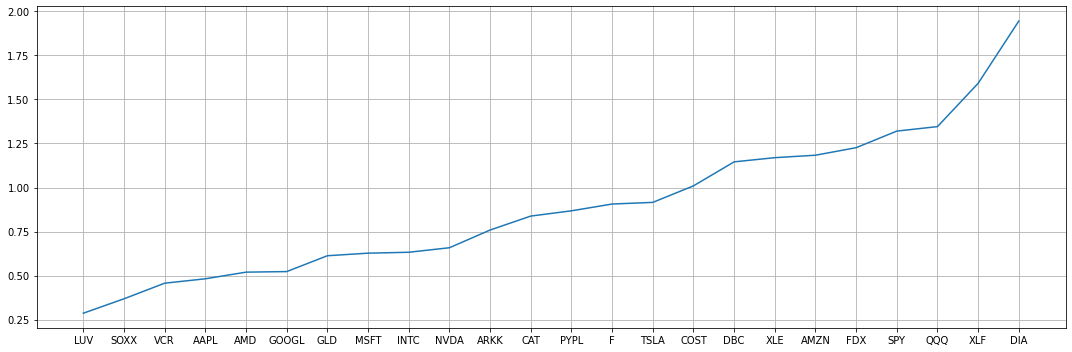

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime

from matplotlib import pyplot as plt
currentDatetime = datetime.datetime.now(mountain)

def options_chain(symbol):
    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options
    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    options['expirationDate'] = pd.to_datetime(options['expirationDate']) 
    options['dte'] = (options['expirationDate'] - datetime.datetime.today()).dt.days / 365
    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])
    return options

predictedVar_list = ["VCR",
                     'DIA',
                'MSFT',
                "GOOGL",
                'TSLA',
                'ARKK',
                'F',
                'SPY',
                'GLD', 
                'QQQ',
                'FDX',
                'COST',
                'PYPL',
                'SOXX',
                'AMD', 
                'NVDA', 
                'INTC',
                'LUV', 
                'DBC',
                'CAT',
                'XLE',
                "XLF",
                'AMZN',
                'AAPL'
                ]

#predictedVar_list = ['MNRL' ]


print('currentDatetime', 'predictedVar', 'callTotal', 'putTotal', 'put_call_ratio')
optionTableSum = pd.DataFrame(columns=['currentDatetime', 'predictedVar', 'callTotal', 'putTotal','put_call_ratio'])
for predictedVar in predictedVar_list:
    optionTable=options_chain(predictedVar)
    optionTable= optionTable.fillna(0)
    #optionTable=optionTable[(optionTable['expirationDate'])] #.between(currentDatetime, (currentDatetime + datetime.timedelta(days = 15))))] 
    optionTable=optionTable[(optionTable['volume']>0) ] # | (optionTable['openInterest']>0)]
    #optionTable=optionTable[(optionTable['openInterest']>0)]
    optionTableCall = optionTable[optionTable['CALL']==True]
    optionTablePut = optionTable[optionTable['CALL']==False]
    callTotal = optionTableCall['volume'].sum()#+optionTableCall['openInterest'].sum()
    putTotal = optionTablePut['volume'].sum()#+optionTablePut['openInterest'].sum()
    put_call_ratio = putTotal/callTotal
    print(currentDatetime, predictedVar, callTotal, putTotal,put_call_ratio)
    optionTableSum = optionTableSum.append({'currentDatetime': currentDatetime,
                                          'predictedVar': predictedVar,
                                          'callTotal': callTotal,
                                          'putTotal': putTotal,
                                          'put_call_ratio': put_call_ratio}, ignore_index=True)

optionTableSum = optionTableSum.sort_values('put_call_ratio')

plt.figure(figsize=(15,5))
plt.plot(optionTableSum['predictedVar'], optionTableSum['put_call_ratio'])
plt.grid()
plt.tight_layout()
